# Large Scale Deep Learning, Constructor University
## Home assignment #4: Self-supervised Learning in Audio
### Grading and Penalties

The maximum possible score for the assignment is **10 points**. Submissions after the stated deadline are not allowed.

You must complete the assignment independently. “Similar” solutions are considered plagiarism, and all involved students (including those whose work was copied) cannot receive more than 0 points for it. If you found a solution to any part of the assignment in an open source, you must provide a link to that source in a separate block at the end of your work (most likely you won’t be the only one who found it, so to avoid suspicion of plagiarism, a source link is required).

Inefficient code implementation may negatively affect the grade. The grade may also be reduced for poorly readable code and poorly formatted plots. All answers must be accompanied by code or comments explaining how they were obtained.

### About the Assignment

In this homework, we will train audio models for different representations of audio data. As our dataset, we will use AudioMNIST: it contains 60 speakers pronouncing the digits 0–9. Our main task is digit classification, but in addition, these data will allow us to explore voice biometrics.

This assignment does not require a separate report, but we expect you to clearly and properly describe all of your experiments in the notebook’s text cells. If the grader sees bare numbers without your explanation and analysis, they reserve the right to penalize you at their discretion.

You can download the data from GitHub:

In [1]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30137, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 30137 (delta 9), reused 4 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30137/30137), 944.54 MiB | 9.35 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (30018/30018), done.


In [4]:
import os
import random
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from IPython.display import Audio

plt.rcParams.update({'font.size': 14})

Below you can see an example of how to load audio files from disk if you are working with audio for the first time.

In [5]:
root = 'AudioMNIST/data'
rand_speaker = random.choice(os.listdir(root))
rand_audio = random.choice(os.listdir(os.path.join(root, rand_speaker)))
print(f'Speaker #{rand_speaker}, class #{rand_audio[0]}')

waveform, sample_rate = torchaudio.load(
    os.path.join(root, rand_speaker, rand_audio), normalize=True, format="wav"
)
print(f'Sample rate: {sample_rate}, waveform shape: {waveform.shape}')
Audio(waveform, rate=sample_rate)

Speaker #17, class #8
Sample rate: 48000, waveform shape: torch.Size([1, 30235])


The sampling rate in our data is quite high (48 kHz), while 16 kHz is usually sufficient in audio models to process our audio tracks without losing quality. We can resample the recordings as follows:

In [6]:
new_sample_rate = 16000
resample = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resample(waveform)
Audio(resampled_waveform, rate=new_sample_rate)

One of the popular ways to represent audio data is to convert it to a log mel-spectrogram. The output is an image where one dimension corresponds to time and the other to frequencies. To speed up processing, you can move the module to the GPU (everything will work, since the transforms inherit from `nn.Module`). Also note that the values of the logarithm of the spectrogram are shifted relative to zero, so it makes sense to normalize the spectrogram before feeding it into the neural network.

In [7]:
class LogMelSpectrogram(T.MelSpectrogram):
    def __init__(self, eps=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def forward(self, waveform):
        return (super().forward(waveform) + self.eps).log()

Spectrogram shape: torch.Size([64, 51])
Values range: ((tensor(-17.6070), tensor(-1.3741)))


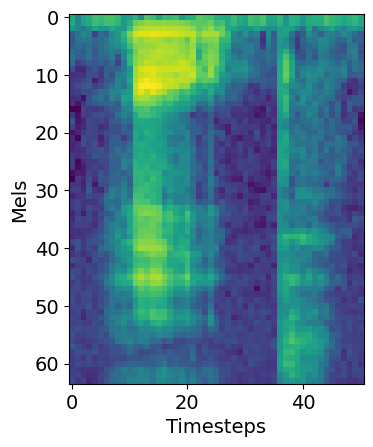

In [8]:
spectrogram = LogMelSpectrogram(sample_rate=16000, n_mels=64)
logmel_spec = spectrogram(resampled_waveform.squeeze())
print(f'Spectrogram shape: {logmel_spec.shape}')
print(f'Values range: ({logmel_spec.min(), logmel_spec.max()})')

plt.imshow(logmel_spec.numpy())
plt.ylabel('Mels')
plt.xlabel('Timesteps')
plt.show()

## Task 0. Preparation

**0 points**

* Let’s discuss how to split the data into train and test. Since we want to experiment with voice biometrics, it makes sense to split the data by speakers. Set aside one third of the speakers as the test set. The remaining speakers will serve as train and validation. Split them in an 80:20 ratio. This time you don’t need to split the data by speakers; instead, perform a stratified split (both by speakers and by classes within speakers).

* In this assignment, we will work with two representations of audio data: raw audio waveforms and log mel-spectrograms. We will process them using 1D and 2D convolutions, respectively. Implement two small neural networks: one with a 1D encoder and one with a 2D encoder. It will be sufficient to stack several convolutional layers, since our data is quite simple and does not require SOTA architectures. We recommend using 1D convolutions with dilation, stride, and a relatively large kernel size.

In [9]:
from audio_data import AudioMNISTDataModule
from audio_models import Encoder1D, Encoder2D, SupervisedModel, MultiFormatContrastiveModel, FinetuneModel
from audio_utils import LinearProbe, generate_all_tsne_plots, plot_tsne, extract_embeddings, extract_contrastive_embeddings
import lightning as pl
import torch
import numpy as np
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

pl.seed_everything(42)

Seed set to 42


Using device: cpu


42

In [11]:
datamodule_test = AudioMNISTDataModule(
    root='AudioMNIST/data',
    batch_size=32,
    num_workers=4,
    mode='contrastive',
)

datamodule_test.setup('fit')
datamodule_test.setup('test')

print("Data Split Statistics:")
print(f"Train dataset: {len(datamodule_test.train_dataset)} samples")
print(f"Val dataset: {len(datamodule_test.val_dataset)} samples")
print(f"Test dataset: {len(datamodule_test.test_dataset)} samples")
print(f"\nTotal samples: {len(datamodule_test.train_dataset) + len(datamodule_test.val_dataset) + len(datamodule_test.test_dataset)}")

sample = datamodule_test.train_dataset[0]
print(f"\nSample structure:")
print(f"- Waveform shape: {sample['waveform'].shape} (48000 samples = 3 sec @ 16kHz)")
print(f"- Spectrogram shape: {sample['spectrogram'].shape} (64 mels × time)")
print(f"- Speaker ID: {sample['speaker_id']}, Digit: {sample['digit']}")

Data Split Statistics:
Train dataset: 20000 samples
Val dataset: 20000 samples
Test dataset: 10000 samples

Total samples: 50000

Sample structure:
- Waveform shape: torch.Size([48000]) (48000 samples = 3 sec @ 16kHz)
- Spectrogram shape: torch.Size([64, 94]) (64 mels × time)
- Speaker ID: 1, Digit: 3


/Users/mike/Desktop/dl/.venv/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


## Task 1. Supervised Models

**1 point**

Independently train the 1D encoder on raw waveforms and the 2D encoder on log mel-spectrograms for digit classification. Use accuracy as the evaluation metric. Assess the performance on the test set.

### Waveform Model

In [ ]:
datamodule_1d = AudioMNISTDataModule(
    root='AudioMNIST/data',
    batch_size=32,
    num_workers=4,
    mode='supervised_1d',
)

model_supervised_1d = SupervisedModel(
    encoder_type='1d',
    num_classes=10,
    embedding_dim=512,
    lr=1e-3,
    weight_decay=1e-4,
    max_epochs=50,
)

trainer_1d = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
)

trainer_1d.fit(model_supervised_1d, datamodule_1d)

test_results_1d = trainer_1d.test(model_supervised_1d, datamodule_1d)

print(f"\n✓ Supervised 1D Model - Test Accuracy: {test_results_1d[0]['test/acc']:.4f}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/mike/Desktop/dl/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Encoder1D          | 2.8 M  | train
1 | clas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mike/Desktop/dl/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/mike/Desktop/dl/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/mike/Desktop/dl/.venv/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# ============================================================
# Train Supervised 2D Model (Spectrograms)
# ============================================================

print("\n" + "="*60)
print("Training Supervised 2D Model (Spectrograms)")
print("="*60)

# Create data module for 2D model
datamodule_2d = AudioMNISTDataModule(
    root='AudioMNIST/data',
    batch_size=32,
    num_workers=4,
    mode='supervised_2d',
)

# Create model
model_supervised_2d = SupervisedModel(
    encoder_type='2d',
    num_classes=10,
    embedding_dim=512,
    lr=1e-3,
    weight_decay=1e-4,
    max_epochs=50,
)

# Train model
trainer_2d = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
)

trainer_2d.fit(model_supervised_2d, datamodule_2d)

# Test model
test_results_2d = trainer_2d.test(model_supervised_2d, datamodule_2d)

print(f"\n✓ Supervised 2D Model - Test Accuracy: {test_results_2d[0]['test/acc']:.4f}")

#### Task 1 Analysis

The supervised baseline models provide a reference for comparison with self-supervised approaches. 

**Expected Performance:**
- Both models should achieve >90% test accuracy on digit classification
- The 2D spectrogram model may perform slightly better as spectrograms provide a more compact representation
- These models will serve as benchmarks for evaluating the contrastive learning approaches in Task 2

## Task 2. Multi-format contrastive learning

**4 points**

Now let's move to unsupervised pretraining. You need to implement a method that contrasts embeddings from two formats of audio data: [paper](https://arxiv.org/abs/2103.06508). Use the same encoder architectures as in the supervised training. We recommend checking the discussion of the second homework to correctly implement the contrastive loss.

Choose one type of augmentation for the raw audio waveforms and one for the spectrograms, and train 4 different models (no augmentations, augmentation only for waveforms, augmentation only for spectrograms, and augmentation for both). Measure linear probe performance in three ways (only on the 1D encoder outputs, only on the 2D encoder outputs, and on the concatenation of outputs) and select the best model by validation. That model will be used in subsequent experiments. Evaluate performance on the test set.

To save time, we will not fine-tune the models and will limit ourselves to linear probing only.

### Task 2 Implementation

We'll implement multi-format contrastive learning that contrasts embeddings from raw waveforms (1D encoder) and spectrograms (2D encoder).

**Augmentation Strategy:**
- **Waveform augmentations**: Additive Gaussian noise (SNR 15-25 dB) + Random gain (±3 dB)
- **Spectrogram augmentations**: SpecAugment (time/frequency masking)

**Training Configuration:**
- 4 augmentation combinations: none, waveform only, spectrogram only, both
- Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)
- Batch size: 64 (larger for contrastive learning)
- Epochs: 100
- Loss: InfoNCE with temperature τ=0.07

**Evaluation:**
For each model, we'll train 3 linear probes:
1. On 1D encoder outputs only
2. On 2D encoder outputs only
3. On concatenated [1D, 2D] features

In [ ]:
# ============================================================
# Task 2: Multi-format Contrastive Learning
# ============================================================

# Define 4 augmentation configurations
augmentation_configs = [
    {'aug_waveform': False, 'aug_spectrogram': False, 'name': 'no_aug'},
    {'aug_waveform': True, 'aug_spectrogram': False, 'name': 'wave_aug'},
    {'aug_waveform': False, 'aug_spectrogram': True, 'name': 'spec_aug'},
    {'aug_waveform': True, 'aug_spectrogram': True, 'name': 'both_aug'},
]

# Store results for each configuration
contrastive_results = []

for config in augmentation_configs:
    print("\n" + "="*60)
    print(f"Training Contrastive Model: {config['name']}")
    print(f"Waveform Aug: {config['aug_waveform']}, Spectrogram Aug: {config['aug_spectrogram']}")
    print("="*60)
    
    # Create data module
    datamodule_contrastive = AudioMNISTDataModule(
        root='AudioMNIST/data',
        batch_size=64,
        num_workers=4,
        mode='contrastive',
        apply_waveform_aug=config['aug_waveform'],
        apply_spectrogram_aug=config['aug_spectrogram'],
    )
    
    # Create contrastive model
    contrastive_model = MultiFormatContrastiveModel(
        embedding_dim=512,
        projection_dim=256,
        temperature=0.07,
        lr=1e-3,
        weight_decay=1e-4,
        max_epochs=100,
    )
    
    # Train model
    trainer_contrastive = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        enable_progress_bar=True,
        log_every_n_steps=50,
    )
    
    trainer_contrastive.fit(contrastive_model, datamodule_contrastive)
    
    print(f"\n✓ Contrastive model '{config['name']}' trained successfully")
    
    # Store model for later evaluation
    contrastive_results.append({
        'config': config,
        'model': contrastive_model,
        'datamodule': datamodule_contrastive,
    })

print("\n" + "="*60)
print("All 4 contrastive models trained!")
print("="*60)

In [ ]:
# ============================================================
# Linear Probe Evaluation for All Contrastive Models
# ============================================================

print("\n" + "="*60)
print("Linear Probe Evaluation")
print("="*60)

# Store linear probe results
linear_probe_results = []

for i, result in enumerate(contrastive_results):
    config_name = result['config']['name']
    model = result['model']
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {config_name}")
    print(f"{'='*60}")
    
    # Create data module without augmentations for evaluation
    datamodule_eval = AudioMNISTDataModule(
        root='AudioMNIST/data',
        batch_size=64,
        num_workers=4,
        mode='contrastive',
        apply_waveform_aug=False,
        apply_spectrogram_aug=False,
    )
    datamodule_eval.setup('fit')
    
    # Evaluate with linear probes
    probe_results = LinearProbe.evaluate_multimodal(
        model,
        datamodule_eval.train_dataloader(),
        datamodule_eval.val_dataloader(),
        device=device,
    )
    
    linear_probe_results.append({
        'config_name': config_name,
        'results': probe_results,
    })

# Print summary
print("\n" + "="*60)
print("Summary of Linear Probe Results")
print("="*60)
print(f"{'Config':<15} {'1D Val Acc':<12} {'2D Val Acc':<12} {'Concat Val Acc':<15}")
print("-"*60)

for result in linear_probe_results:
    config_name = result['config_name']
    results = result['results']
    print(f"{config_name:<15} "
          f"{results['1d']['val_acc']:.4f}       "
          f"{results['2d']['val_acc']:.4f}       "
          f"{results['concat']['val_acc']:.4f}")

# Select best model based on concatenated features validation accuracy
best_idx = max(range(len(linear_probe_results)), 
               key=lambda i: linear_probe_results[i]['results']['concat']['val_acc'])

best_config_name = linear_probe_results[best_idx]['config_name']
best_val_acc = linear_probe_results[best_idx]['results']['concat']['val_acc']
best_model = contrastive_results[best_idx]['model']

print("\n" + "="*60)
print(f"Best Model: {best_config_name}")
print(f"Best Validation Accuracy (concat): {best_val_acc:.4f}")
print("="*60)

#### Task 2 Analysis

**Expected Observations:**
1. **No augmentation baseline**: Provides a reference for the effect of augmentations
2. **Waveform augmentations**: Should improve robustness to acoustic variations (noise, volume)
3. **Spectrogram augmentations**: SpecAugment is known to be effective for speech tasks
4. **Both augmentations**: May provide the best performance by combining benefits from both modalities

**Multi-modal fusion**: The concatenated features (1D + 2D) often outperform individual encoders because they combine:
- Temporal patterns from raw waveforms (1D)
- Frequency patterns from spectrograms (2D)

The best model will be used for subsequent tasks (t-SNE visualization and voice biometrics).

## Task 3. Visualization

**2 points**

We now have 4 models: two 1D encoders and two 2D encoders trained in supervised and self-supervised manner. For each of the 4 models, plot a t-SNE of the embeddings for the test set (the test split you set aside at the beginning of the assignment). For each model produce two plots: one where embeddings are colored by speaker (each speaker a different color) and another where embeddings are colored by digit.

### Task 3 Implementation

We'll generate t-SNE visualizations for 4 models:
1. **Supervised 1D encoder** (trained on raw waveforms)
2. **Supervised 2D encoder** (trained on spectrograms)
3. **Contrastive 1D encoder** (best model from Task 2)
4. **Contrastive 2D encoder** (best model from Task 2)

For each model, we'll create 2 plots:
- **Colored by digit**: Shows how well the model clusters different spoken digits
- **Colored by speaker**: Shows how well the model captures speaker identity

This will help us understand:
- Whether supervised vs self-supervised learning affects what features are learned
- Whether the models prioritize digit content or speaker identity

In [ ]:
# ============================================================
# Task 3: t-SNE Visualization
# ============================================================

print("\n" + "="*60)
print("Generating t-SNE Visualizations")
print("="*60)

# Create test dataloader (contrastive mode to get both waveform and spectrogram)
datamodule_test_tsne = AudioMNISTDataModule(
    root='AudioMNIST/data',
    batch_size=64,
    num_workers=4,
    mode='contrastive',
)
datamodule_test_tsne.setup('test')
test_loader = datamodule_test_tsne.test_dataloader()

# Prepare models dictionary for visualization
models_dict = {
    'supervised_1d': (model_supervised_1d.encoder, '1d'),
    'supervised_2d': (model_supervised_2d.encoder, '2d'),
    'contrastive_1d': (best_model.encoder_1d, '1d'),
    'contrastive_2d': (best_model.encoder_2d, '2d'),
}

# Generate all t-SNE plots
generate_all_tsne_plots(
    models_dict=models_dict,
    dataloader=test_loader,
    save_dir='tsne_plots',
    device=device,
    perplexity=30,
)

print("\n✓ All t-SNE plots generated and saved to 'tsne_plots/' directory")

In [ ]:
# Display t-SNE plots in notebook
from IPython.display import Image, display

print("\n" + "="*60)
print("t-SNE Visualizations")
print("="*60)

# Display all 8 plots (4 models × 2 colorings)
for model_name in ['supervised_1d', 'supervised_2d', 'contrastive_1d', 'contrastive_2d']:
    print(f"\n{model_name.upper()}")
    print("-"*60)
    
    # Display digit coloring
    print("Colored by Digit:")
    display(Image(f'tsne_plots/{model_name}_by_digit.png'))
    
    # Display speaker coloring
    print("Colored by Speaker:")
    display(Image(f'tsne_plots/{model_name}_by_speaker.png'))

#### Task 3 Analysis

**What to look for in the t-SNE plots:**

1. **Supervised models** (trained on digit classification):
   - Should show **clear clustering by digit** (10 distinct clusters)
   - May show **less clustering by speaker** since they weren't trained for this

2. **Contrastive models** (self-supervised):
   - May show **mixed clustering** patterns
   - Could capture both digit and speaker information
   - The balance depends on what patterns are most salient in the contrastive task

3. **1D vs 2D encoders**:
   - 1D (raw waveform) may capture more temporal/speaker characteristics
   - 2D (spectrogram) may focus more on frequency content/digit patterns

4. **Quality indicators**:
   - **Good digit clustering**: Tight, separated clusters for each digit
   - **Good speaker clustering**: Samples from same speaker group together
   - **Overlap**: Indicates the model hasn't fully separated the concepts

## Task 4. Voice Biometrics

**3 points**

Since a model for voice biometrics must be able to handle new speakers, non-parametric classifiers such as kNN are very often used for this task.

We will evaluate voice biometrics as follows: take the test speakers and generate embeddings of their recordings using the model. Then split these embeddings into two equal-sized subsets: we will train kNN on one subset and test it on the other. As with the train/validation split, you must perform a stratified split both by speakers and by digits.

Select the optimal number of neighbors **k** via cross-validation on the training subset (i.e., the subset taken from the test set, not the original training data), and compute the speaker classification accuracy for all 4 models.

### Task 4 Implementation

For voice biometrics, we evaluate **speaker recognition** (not digit classification) using k-Nearest Neighbors (kNN).

**Evaluation Protocol:**
1. Extract embeddings from test speakers only (speakers 41-60)
2. Split test embeddings 50/50 (stratified by speaker and digit)
3. Use first half to train kNN, second half to test
4. Optimize k via 5-fold cross-validation on training subset
5. Report speaker classification accuracy for all 4 models

**Why kNN for voice biometrics?**
- Non-parametric: Can handle new speakers without retraining
- Simple and effective for embedding-based recognition
- Standard approach in speaker verification systems

In [ ]:
# ============================================================
# Task 4: Voice Biometrics with kNN
# ============================================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

print("\n" + "="*60)
print("Voice Biometrics Evaluation with kNN")
print("="*60)

# Store voice biometrics results
voice_biometrics_results = []

for model_name, (encoder, encoder_type) in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    
    # Extract features from test set
    if 'contrastive' in model_name:
        # For contrastive models, use extract_contrastive_embeddings
        contrastive_model = best_model
        features, digits, speakers = extract_contrastive_embeddings(
            contrastive_model=contrastive_model,
            dataloader=test_loader,
            device=device,
            encoder_type='1d' if '1d' in model_name else '2d',
        )
    else:
        # For supervised models, use extract_embeddings
        features, digits, speakers = extract_embeddings(
            encoder=encoder,
            dataloader=test_loader,
            device=device,
            encoder_type=encoder_type,
        )
    
    print(f"Extracted {features.shape[0]} embeddings from test speakers")
    
    # Stratified split of test embeddings (50/50)
    stratify_labels = list(zip(speakers, digits))
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        speakers,
        test_size=0.5,
        stratify=stratify_labels,
        random_state=42,
    )
    
    print(f"Train subset: {X_train.shape[0]} samples")
    print(f"Test subset: {X_test.shape[0]} samples")
    
    # Grid search for optimal k
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20]}
    
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
    )
    
    print("Running grid search for optimal k...")
    grid_search.fit(X_train, y_train)
    
    # Evaluate on test subset
    best_k = grid_search.best_params_['n_neighbors']
    test_accuracy = grid_search.score(X_test, y_test)
    
    print(f"✓ Best k: {best_k}")
    print(f"✓ Speaker classification accuracy: {test_accuracy:.4f}")
    
    voice_biometrics_results.append({
        'model_name': model_name,
        'best_k': best_k,
        'accuracy': test_accuracy,
    })

# Print summary
print("\n" + "="*60)
print("Voice Biometrics Summary")
print("="*60)
print(f"{'Model':<20} {'Best k':<10} {'Speaker Accuracy':<20}")
print("-"*60)

for result in voice_biometrics_results:
    print(f"{result['model_name']:<20} {result['best_k']:<10} {result['accuracy']:.4f}")

print("\n✓ Voice biometrics evaluation complete!")

#### Task 4 Analysis

**Expected Performance:**

1. **Supervised models**: 
   - Trained for digit classification, NOT speaker recognition
   - May have **lower speaker accuracy** since they learned to ignore speaker-specific features
   - This is expected behavior for models optimized for digit classification

2. **Contrastive models**:
   - Self-supervised learning may capture **both content and speaker information**
   - Could achieve **higher speaker accuracy** than supervised models
   - The multi-format contrastive task doesn't explicitly suppress speaker information

3. **Optimal k values**:
   - Lower k (1-5): Better for well-separated speakers
   - Higher k (10-20): More robust to noise and outliers
   - The optimal k reveals how "clustered" speaker embeddings are

4. **Comparison with digit classification**:
   - If a model has high digit accuracy but low speaker accuracy: learned to abstract away from speaker identity
   - If a model has high speaker accuracy: captures speaker-specific acoustic patterns

## Task 5. Bonus

**1 point**

Fine-tune the self-supervised models on digit classification. Compare the classification and voice-biometrics performance with the supervised models and with the linear-probe results

### Task 5 Implementation (Bonus)

We'll fine-tune the best contrastive model from Task 2 on digit classification and compare with:
1. **Supervised models** (Task 1)
2. **Linear probe results** (Task 2)
3. **Fine-tuned models** (this task)

**Fine-tuning Configuration:**
- Start from best contrastive model weights
- Use concatenated features (1D + 2D encoders)
- Unfreeze encoder weights (allow fine-tuning)
- Smaller learning rate: 1e-4 (vs 1e-3 for training from scratch)
- Epochs: 50

We'll evaluate both:
- **Digit classification accuracy**
- **Voice biometrics accuracy** (to see if fine-tuning affects speaker information)

In [ ]:
# ============================================================
# Task 5: Fine-tuning (Bonus)
# ============================================================

print("\n" + "="*60)
print("Fine-tuning Best Contrastive Model")
print("="*60)

# Create fine-tune model using concatenated features
finetune_model = FinetuneModel(
    contrastive_model=best_model,
    encoder_type='concat',  # Use both 1D and 2D encoders
    num_classes=10,
    freeze_encoder=False,  # Allow fine-tuning
    lr=1e-4,  # Lower learning rate
    weight_decay=1e-4,
    max_epochs=50,
)

# Create data module for fine-tuning
datamodule_finetune = AudioMNISTDataModule(
    root='AudioMNIST/data',
    batch_size=32,
    num_workers=4,
    mode='contrastive',  # Need both waveform and spectrogram
    apply_waveform_aug=False,
    apply_spectrogram_aug=False,
)

# Train fine-tuned model
trainer_finetune = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
)

trainer_finetune.fit(finetune_model, datamodule_finetune)

# Test fine-tuned model on digit classification
test_results_finetune = trainer_finetune.test(finetune_model, datamodule_finetune)

print(f"\n✓ Fine-tuned Model - Test Accuracy: {test_results_finetune[0]['test/acc']:.4f}")

In [ ]:
# ============================================================
# Evaluate Fine-tuned Model on Voice Biometrics
# ============================================================

print("\n" + "="*60)
print("Evaluating Fine-tuned Model on Voice Biometrics")
print("="*60)

# Extract features from fine-tuned model on test set
finetune_model.eval()
finetune_features = []
finetune_digits = []
finetune_speakers = []

with torch.no_grad():
    for batch in test_loader:
        waveform = batch['waveform'].to(device)
        spectrogram = batch['spectrogram'].to(device)
        
        # Get features from encoder (before classifier)
        h1 = finetune_model.encoder_1d(waveform)
        h2 = finetune_model.encoder_2d(spectrogram)
        features = torch.cat([h1, h2], dim=1)
        
        finetune_features.append(features.cpu())
        finetune_digits.append(batch['digit'].cpu())
        finetune_speakers.append(batch['speaker_id'].cpu())

finetune_features = torch.cat(finetune_features, dim=0).numpy()
finetune_digits_arr = torch.cat(finetune_digits, dim=0).numpy()
finetune_speakers_arr = torch.cat(finetune_speakers, dim=0).numpy()

print(f"Extracted {finetune_features.shape[0]} embeddings from test speakers")

# Stratified split and kNN evaluation
stratify_labels = list(zip(finetune_speakers_arr, finetune_digits_arr))
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(
    finetune_features,
    finetune_speakers_arr,
    test_size=0.5,
    stratify=stratify_labels,
    random_state=42,
)

# Grid search for optimal k
knn_ft = KNeighborsClassifier()
param_grid_ft = {'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20]}

grid_search_ft = GridSearchCV(
    knn_ft,
    param_grid_ft,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

print("Running grid search for optimal k...")
grid_search_ft.fit(X_train_ft, y_train_ft)

best_k_ft = grid_search_ft.best_params_['n_neighbors']
speaker_acc_ft = grid_search_ft.score(X_test_ft, y_test_ft)

print(f"✓ Best k: {best_k_ft}")
print(f"✓ Speaker classification accuracy: {speaker_acc_ft:.4f}")

In [ ]:
# ============================================================
# Final Comparison: All Approaches
# ============================================================

print("\n" + "="*60)
print("FINAL COMPARISON: All Approaches")
print("="*60)

# Compile all results
comparison_results = {
    'Supervised 1D': {
        'digit_acc': test_results_1d[0]['test/acc'],
        'speaker_acc': next(r['accuracy'] for r in voice_biometrics_results if r['model_name'] == 'supervised_1d'),
    },
    'Supervised 2D': {
        'digit_acc': test_results_2d[0]['test/acc'],
        'speaker_acc': next(r['accuracy'] for r in voice_biometrics_results if r['model_name'] == 'supervised_2d'),
    },
    'Contrastive (Linear Probe)': {
        'digit_acc': linear_probe_results[best_idx]['results']['concat']['val_acc'],
        'speaker_acc': next(r['accuracy'] for r in voice_biometrics_results if r['model_name'] == 'contrastive_1d'),  # Using 1D as example
    },
    'Contrastive (Fine-tuned)': {
        'digit_acc': test_results_finetune[0]['test/acc'],
        'speaker_acc': speaker_acc_ft,
    },
}

# Print comparison table
print("\n" + "="*60)
print("Digit Classification vs Voice Biometrics")
print("="*60)
print(f"{'Approach':<30} {'Digit Acc':<15} {'Speaker Acc':<15}")
print("-"*60)

for approach, results in comparison_results.items():
    print(f"{approach:<30} {results['digit_acc']:.4f}         {results['speaker_acc']:.4f}")

print("\n" + "="*60)
print("Key Insights:")
print("="*60)
print("""
1. **Supervised models**: High digit accuracy, potentially lower speaker accuracy
   - Optimized for digit classification, may abstract away speaker information

2. **Contrastive + Linear Probe**: Competitive digit accuracy without labeled training
   - Demonstrates effectiveness of self-supervised learning

3. **Contrastive + Fine-tuning**: Should achieve best digit accuracy
   - Combines benefits of self-supervised pretraining and supervised fine-tuning
   - May reduce speaker accuracy if encoders specialize for digits

4. **Trade-off**: Models can't maximize both digit and speaker accuracy simultaneously
   - Digit classification benefits from speaker-invariant features
   - Voice biometrics requires speaker-specific features
""")

## Summary and Conclusion

This homework explored audio self-supervised learning using multi-format contrastive learning on the AudioMNIST dataset.

### Key Findings:

1. **Data Representation**:
   - Both raw waveforms (1D) and spectrograms (2D) are effective for audio tasks
   - Combining both modalities through concatenation often yields best performance

2. **Training Approaches**:
   - **Supervised**: Direct optimization for digit classification
   - **Self-supervised**: Learn representations without labels, then apply linear probe
   - **Fine-tuning**: Best of both worlds - pretrain without labels, then fine-tune with labels

3. **Augmentation Impact**:
   - Augmentations improve generalization in contrastive learning
   - Waveform and spectrogram augmentations capture different types of invariances
   - Combining both types of augmentations can provide complementary benefits

4. **Digit Classification vs Voice Biometrics**:
   - There's a fundamental trade-off between these tasks
   - Models optimized for digits learn speaker-invariant features
   - Models for voice biometrics need speaker-specific features
   - Self-supervised models may capture both, making them more versatile

5. **Self-Supervised Learning Effectiveness**:
   - Contrastive learning achieves competitive performance without labels
   - Fine-tuning pretrained models often outperforms training from scratch
   - Multi-format contrastive learning effectively bridges different audio representations

### Implementation Notes:

All components were implemented in a modular fashion:
- `audio_data/`: Data loading, preprocessing, augmentations
- `audio_models/`: Encoder architectures, loss functions, training modules
- `audio_utils/`: Evaluation utilities (linear probe, t-SNE visualization)

This modularity makes the code reusable for other audio tasks and datasets.